### Table of contents
1. [Create CAS Connection](#casConnection)
2. [Load Data and Sample](#dataLoadSample)
3. [Explore Data](#exploreData)
4. [Begin Modeling](#beginModel)
   - [Random Forest Model](#randomForest)
   - [Gradient Boosted Model](#gradientBoost)
   - [Deep Learning Model](#deepLearn)

In [2]:
# Import Libraries
import swat
from time import time
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

<a name="casConnection"></a>

<div class="alert alert-success">
<b>Create CAS Connection and Set CAS Library</b>
</div>

In [3]:
# Create Cloud Analytic Server (CAS) Connection
conn = swat.CAS(host, portnum, user, password)

In [4]:
# Setup a CAS Library
conn.addcaslib(activeonadd=True,
                     datasource={'srctype':'path'},
                     name='bankDataLib',
                     path='/cas/DeepLearn/anviol/data/',
                     subdirectories=True);

NOTE: 'bankDataLib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'bankDataLib'.


<a name="dataLoadSample"></a>

<div class="alert alert-success">
<b>Load Bank Data to CAS and Sampling</b>
</div>

In [5]:
# Load the Bank Data to the CAS Library we Just Set Up
start = time()
data = conn.read_sas('/Users/anviol/Desktop/Content/Datasets/cs_accepts.sas7bdat',
                     casout={"name":"data",
                             "replace":True,
                             "caslib":"bankDataLib"})
end = time()

print("Bank Data Load Time: %.2f Seconds" %(end - start))

NOTE: Cloud Analytic Services made the uploaded file available as table DATA in caslib bankDataLib.
NOTE: The table DATA has been created in caslib bankDataLib from binary data uploaded to Cloud Analytic Services.
Bank Data Load Time: 124.44 Seconds


In [6]:
# Data Size
data.shape

(2239500, 27)

In [7]:
# Sampling Action Set
conn.loadactionset(actionset="sampling")

# Apply Stratified Sampling by Target Variable(70/30 Split)
conn.stratified(samppct=30,
                partind=True,
                seed=10,
                table={"name":"data", "groupBy":{"target"}},
                output={"casOut":{"name":"dataSample", "replace":True},
                        "copyVars":"ALL"});

NOTE: Added action set 'sampling'.
NOTE: Using SEED=10 for sampling.


In [8]:
# See Tables Loaded to CAS
conn.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,DATA,2239500,27,0,utf-8,2018-10-18T11:41:15-04:00,2018-10-18T11:41:15-04:00,2018-10-18T11:41:37-04:00,UTF8,1.855496e+09,...,0,0,0,,,0,anviol,,2018-10-18T11:41:14-04:00,1.855496e+09
1,DATASAMPLE,2239500,28,0,utf-8,2018-10-18T11:41:37-04:00,2018-10-18T11:41:37-04:00,2018-10-18T11:41:37-04:00,UTF8,1.855496e+09,...,0,0,0,,,0,anviol,,,NaN


<a name="exploreData"></a>

<div class="alert alert-success">
<b>Explore Data</b>
</div>

In [9]:
# Remove Column Display Suppression
pd.set_option('display.max_columns', None)

# View Head of Data
conn.CASTable('dataSample').head()

,_customerID,target,title,Nchildren,Nhousehold,Age,TimeAddress,TimeJob,tel,NumMyLoan,NumFinLoan,NumLoans,Income,EC_Card,IncLevel,status,bureau,region,regionLarge,cash,product,resid,nat,prof,car,card,saving,_PartInd_
0,b'c001807326',b'Good',b'R',3.0,4.0,41.0,18.0,15.0,b'2',0.0,0.0,1.0,0.0,b'1',b'0',b'W',b'1',b'6',b'1',1100.0,b'Electronics',b'Lease',b'German',b'N/A',b'Car',b'Yes',b'Yes',0.0
1,b'c001807327',b'Bad',b'H',0.0,1.0,25.0,72.0,24.0,b'1',0.0,1.0,1.0,2300.0,b'0',b'1',b'U',b'1',b'6',b'1',1000.0,b'Leisure',b'Lease',b'German',b'N/A',b'Car and Motor',b'No',b'N/A',1.0
2,b'c001807328',b'Bad',b'H',1.0,3.0,32.0,3.0,15.0,b'2',0.0,1.0,2.0,2500.0,b'0',b'1',b'V',b'1',b'5',b'1',5000.0,b'Cars',b'Lease',b'German',b'F',b'Without Vehicle',b'No',b'Yes',1.0
3,b'c001807329',b'Good',b'H',0.0,2.0,28.0,21.0,84.0,b'1',0.0,0.0,1.0,5000.0,b'0',b'2',b'V',b'1',b'5',b'1',1700.0,b'Electronics',b'Lease',b'German',b'N/A',b'Car',b'No',b'No',0.0
4,b'c001807330',b'Bad',b'H',0.0,1.0,28.0,42.0,66.0,b'1',0.0,0.0,4.0,0.0,b'0',b'0',b'U',b'1',b'8',b'1',2500.0,b'Electronics',b'Lease',b'German',b'G',b'Car',b'Yes',b'No',1.0


In [10]:
# View Target Distribution
data['target'].freq()

,Column,CharVar,FmtVar,Level,Frequency
0,target,b'Bad',b'Bad',1,448500.0
1,target,b'Good',b'Good',2,1791000.0


In [11]:
# Numeric Variables Summary
conn.CASTable('dataSample').describe()

,Nchildren,Nhousehold,Age,TimeAddress,TimeJob,NumMyLoan,NumFinLoan,NumLoans,Income,cash,_PartInd_
count,2.239500e+06,2.239500e+06,2.239500e+06,2.159783e+06,2.208749e+06,2.239500e+06,2.239500e+06,2.239500e+06,2.239500e+06,2.239500e+06,2.239500e+06
mean,8.769609e-01,2.479304e+00,3.594185e+01,9.363731e+01,7.870231e+01,5.944836e-01,4.962393e-01,9.294159e-01,1.950470e+03,2.307495e+03,3.000000e-01
std,1.048498e+00,1.339041e+00,1.130997e+01,8.864195e+01,8.305635e+01,8.863378e-01,4.999860e-01,1.074735e+00,1.575188e+03,2.655320e+03,4.582577e-01
min,0.000000e+00,1.000000e+00,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,2.700000e+01,2.100000e+01,2.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+03,0.000000e+00
50%,1.000000e+00,2.000000e+00,3.400000e+01,6.000000e+01,4.500000e+01,0.000000e+00,0.000000e+00,1.000000e+00,2.100000e+03,1.500000e+03,0.000000e+00
75%,2.000000e+00,3.000000e+00,4.300000e+01,1.440000e+02,1.080000e+02,2.000000e+00,1.000000e+00,1.000000e+00,2.800000e+03,2.500000e+03,1.000000e+00
max,6.000000e+00,8.000000e+00,7.200000e+01,3.840000e+02,3.600000e+02,2.000000e+00,1.000000e+00,9.000000e+00,1.000000e+04,2.000000e+04,1.000000e+00


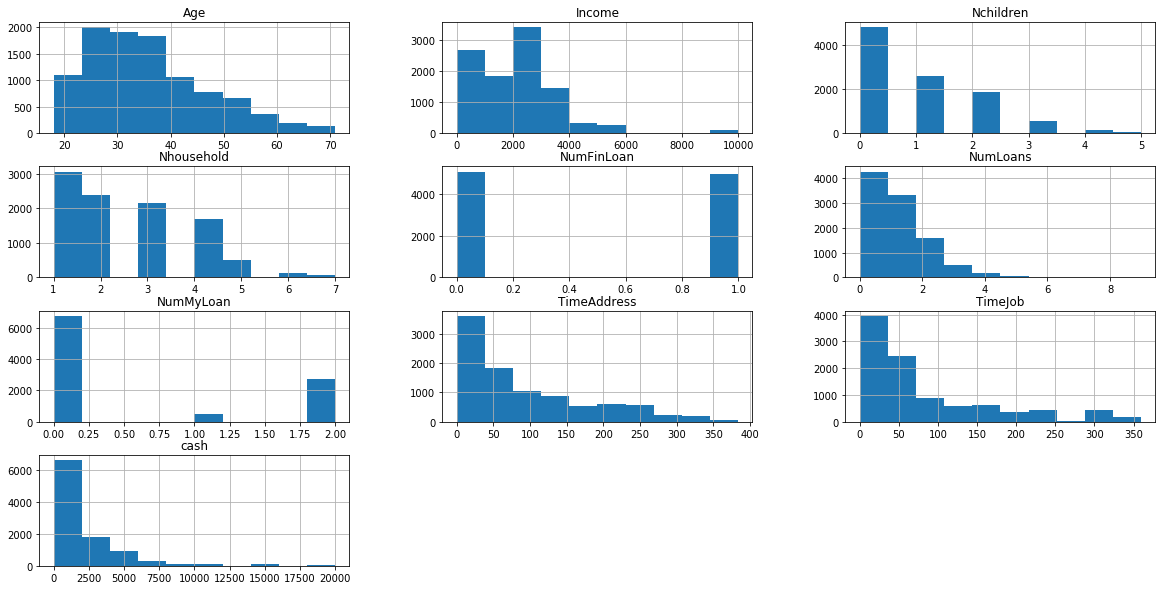

In [12]:
# Visualize Numeric Variable Distributions
data.hist(figsize = (20, 10));

<a name="beginModel"></a>

<div class="alert alert-success">
<b>Begin Modeling</b>
</div>

In [13]:
# Set Inputs and Target
inputs = list(data.drop(['_customerID','target'], axis=1))
target = 'target'

<a name="randomForest"></a>

<div class="alert alert-info">
<b>Random Forests</b>
</div>

In [14]:
# Load the Decision Tree Action Set
conn.loadactionset('decisionTree');

NOTE: Added action set 'decisionTree'.


In [15]:
# Create Place Holder for 'rf_model'
rf_model = conn.CASTable("rf_model",replace = True)

In [16]:
start = time()

# Fit Random Forest Model
out_rf = conn.forestTrain(
            table = dict(name='dataSample', where='_PartInd_=0.0'), 
            target = target,
            inputs = inputs,
            bootstrap = 0.60,
            crit = "GINI",
            ntree = 500,
            m = 20,
            vote = 'PROB',
            varimp = True, # The importance value is determined by the total Gini reduction.
            oob = True,
            seed = 12345,
            casout = rf_model)

end = time()
print("Random Forest Train Time: %.2f Seconds" %(end - start))

Random Forest Train Time: 36.99 Seconds


In [17]:
# Model Info Including Misclassification Rate
out_rf['ModelInfo']

,Descr,Value
0,Number of Trees,500.000000
1,Number of Selected Variables (M),20.000000
2,Random Number Seed,12345.000000
3,Bootstrap Percentage (%),60.000000
4,Number of Bins,20.000000
5,Number of Variables,25.000000
6,Confidence Level for Pruning,0.250000
7,Max Number of Tree Nodes,63.000000
8,Min Number of Tree Nodes,51.000000
9,Max Number of Branches,2.000000


In [18]:
# Variable Importance
out_rf['DTreeVarImpInfo'].head(n=10)

,Variable,Importance,Std
0,Age,14092.704404,4631.091732
1,status,5773.779673,3092.862942
2,card,5734.752055,1368.499406
3,nat,2827.942770,485.454449
4,region,2565.062763,492.131227
5,prof,1945.239126,348.748437
6,NumLoans,1426.946250,290.963983
7,TimeJob,1337.622628,511.337693
8,car,1080.195449,292.519832
9,Nhousehold,1072.868252,1481.324109


In [19]:
# Score Test Data
dataSample = conn.CASTable('dataSample')

forestScore = conn.decisionTree.forestscore(
                    modelTable=rf_model,
                    copyVars=['target'],
                    casOut={"name":"forestScored", "replace":True}, 
                    vote='prob',
                    table=dict(name='dataSample', where='_PartInd_=1.0'),
                    encodeName=True)

In [20]:
# Show Score
forestScore['ScoreInfo']

,Descr,Value
0,Number of Observations Read,671850
1,Number of Observations Used,671850
2,Misclassification Error (%),18.370469599


 <a name="gradientBoost"></a>

<div class="alert alert-info">
<b>Gradient Boosted Trees</b>
</div>

In [21]:
# Create Place Holder for 'rf_model'
gb_model = conn.CASTable("gb_model",replace = True)

In [22]:
start = time()

# Fit Gradient Boosted Model
out_gb = conn.gbtreeTrain(
            table = dict(name='dataSample', where='_PartInd_=0.0'), 
            target = target,
            inputs = inputs,
            binOrder=True,
            maxlevel=8,
            nbins=100,
            nTree=75,
            varImp=True,
            seed = 12345,
            validTable = dict(name='dataSample', where='_PartInd_=1.0'),
            casout = gb_model)

end = time()
print("Gradient Boosting Train Time: %.2f Seconds" %(end - start))

Gradient Boosting Train Time: 68.31 Seconds


In [23]:
# Model Info
out_gb['ModelInfo']

,Descr,Value
0,Number of Trees,75.0
1,Distribution,2.0
2,Learning Rate,0.1
3,Subsampling Rate,0.5
4,Number of Selected Variables (M),25.0
5,Number of Bins,100.0
6,Number of Variables,25.0
7,Max Number of Tree Nodes,255.0
8,Min Number of Tree Nodes,179.0
9,Max Number of Branches,2.0


In [24]:
# Variable Importance
out_gb['DTreeVarImpInfo'].head(n=10)

,Variable,Importance,Std
0,Age,2789.543434,1012.468100
1,region,2108.958122,209.836061
2,TimeJob,1527.749940,208.961694
3,TimeAddress,1488.337399,182.716611
4,prof,1354.649694,205.761915
5,cash,1233.380879,180.205605
6,Income,976.745107,180.098211
7,nat,782.697239,230.727413
8,card,723.018520,701.347584
9,product,639.817122,163.708321


In [25]:
# Score the Test Data
gbScore = conn.decisionTree.gbtreeScore(
                modelTable = gb_model,
                copyVars = ['target'],
                casOut = {"name":"forestScored", "replace":True},
                table = dict(name='dataSample', where='_PartInd_=1.0'),
                encodeName = True)

In [26]:
# Show Score
gbScore['ScoreInfo']

,Descr,Value
0,Number of Observations Read,671850
1,Number of Observations Used,671850
2,Misclassification Error (%),5.6607873781


<a name="deepLearn"></a>

<div class="alert alert-info">
<b>Deep Neural Network</b>
</div>

In [28]:
# Load the Deep Learn Action Set
conn.loadactionset(actionset='deepLearn');

NOTE: Added action set 'deepLearn'.


In [35]:
# Set Up Deep Learning Model Architecture
conn.buildModel(model=dict(name='modelDNN', replace=True), type='DNN')

conn.addlayer(model='modelDNN', name='dataInputs', replace=True,
             layer=dict(type='input', std='STD'))

conn.addlayer(model='modelDNN', name='FC1', replace=True,
             layer=dict(type='FC', act='RECTIFIER', n=32, init='XAVIER'), srcLayers=['dataInputs'])

conn.addlayer(model='modelDNN', name='FC2', replace=True,
             layer=dict(type='FC', act='RECTIFIER', n=32, dropout=0.3, init='XAVIER'), srcLayers=['FC1'])

conn.addLayer(model='modelDNN', name='outLayer', replace=True, 
           layer=dict(type='OUTPUT', n=2, act='LOGISTIC'), srcLayers=['FC2'])

conn.modelInfo(model='modelDNN')

,Descr,Value
0,Model Name,modeldnn
1,Model Type,Deep Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Fully Connected Layers,2


In [36]:
start = time()

# Train Deep Learning Model
out_dnn = conn.dltrain(
                model = 'modelDNN', 
                table = dict(name='dataSample', where='_PartInd_=0.0'),
                validTable = dict(name='dataSample', where='_PartInd_=1.0'),
                nthreads = 2,
                inputs = inputs, 
                target = target,
                modelWeights = {"name":"modelDNNWeights", "replace":True},
                optimizer = dict(
                    miniBatchSize = 32,
                    algorithm = dict(method='ADAM', learningRate=0.001),
                    maxEpochs = 10, 
                    loglevel = 2))
end = time()

print("Deep Learning Train Time: %.2f Seconds" %(end - start))

NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 3522.
NOTE:  The approximate memory cost is 1.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       1.53 (s).
NOTE:  The total number of workers is 5.
NOTE:  The total number of threads on each worker is 2.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 320.
NOTE:  Target variable: target
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: b'Good'
NOTE:  Level      1: b'Bad' 
NOTE:  Number of input variables:    25
NOTE:  Number of nominal input variables:     15
NOTE:  Number of numeric input variables:     10
NOTE:  Epoch           Learning Rate     Loss    Fit Error   Validation Loss   Validation Error    Time (s)
NOTE:          0           0.001       0.3236     0.1274          0.2451           0.0916 

In [37]:
# Model Info with Parameters
out_dnn['ModelInfo']

,Descr,Value
0,Model Name,modeldnn
1,Model Type,Deep Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Fully Connected Layers,2
6,Number of Weight Parameters,3456
7,Number of Bias Parameters,66
8,Total Number of Model Parameters,3522
9,Approximate Memory Cost for Training (MB),1
